In [40]:
import pandas as pd
# 원본 데이터 읽기
test = pd.read_csv("test색상검출완료.csv", header=None, names=["Label", "RGB"])
train = pd.read_csv("train색상검출완료.csv", header=None, names=["Label", "RGB"])
valid = pd.read_csv("valid색상검출완료.csv", header=None, names=["Label", "RGB"])

test

,Label,RGB
0,0.0,"(56, 47, 30)"
1,1.0,"(47, 52, 48)"
2,0.0,"(150, 194, 191)"
3,1.0,"(57, 46, 35)"
4,0.0,"(117, 138, 112)"
...,...,...
80,1.0,"(30, 38, 41)"
81,0.0,"(210, 86, 16)"
82,1.0,"(141, 130, 109)"
83,0.0,"(24, 30, 26)"


In [42]:
train

,Label,RGB
0,0.0,"(103, 109, 101)"
1,1.0,"(17, 27, 28)"
2,0.0,"(176, 182, 181)"
3,1.0,"(47, 51, 47)"
4,0.0,"(90, 120, 142)"
...,...,...
477,1.0,"(74, 85, 86)"
478,0.0,"(72, 77, 88)"
479,1.0,"(119, 137, 139)"
480,0.0,"(81, 77, 68)"


In [44]:
valid

,Label,RGB
0,0.0,"(185, 188, 190)"
1,1.0,"(97, 98, 88)"
2,0.0,"(120, 200, 206)"
3,1.0,"(120, 119, 118)"
4,0.0,"(163, 161, 155)"
...,...,...
144,1.0,"(127, 64, 53)"
145,0.0,"(36, 100, 66)"
146,1.0,"(78, 92, 88)"
147,0.0,"(142, 140, 141)"


# 일부 인덱스에서는 상의 또는 하의 데이터가 없는 경우가 있기 때문에 상의를 의미하는 0 뒤에 하의를 의미하는 1이 있는 경우만 남긴다.

In [45]:
# 0 뒤에 1이 있는 경우만 남기기
test1 = test[test["Label"].eq(1.0) | test["Label"].shift(-1).eq(1.0)].reset_index(drop=True)
train1 = train[train["Label"].eq(1.0) | train["Label"].shift(-1).eq(1.0)].reset_index(drop=True)
valid1 = valid[valid["Label"].eq(1.0) | valid["Label"].shift(-1).eq(1.0)].reset_index(drop=True)

In [46]:
# 상의와 하의 데이터프레임 나누기
test_tops = test1[test1["Label"] == 0.0].reset_index(drop=True)
test_bottoms = test1[test1["Label"] == 1.0].reset_index(drop=True)

train_tops = train1[train1["Label"] == 0.0].reset_index(drop=True)
train_bottoms = train1[train1["Label"] == 1.0].reset_index(drop=True)

valid_tops = valid1[valid1["Label"] == 0.0].reset_index(drop=True)
valid_bottoms = valid1[valid1["Label"] == 1.0].reset_index(drop=True)


# tops 데이터프레임의 열 이름을 "TOP_RGB"로 변경
test_tops = test_tops.rename(columns={"RGB": "TOP_RGB"})
test_bottoms = test_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})

train_tops = train_tops.rename(columns={"RGB": "TOP_RGB"})
train_bottoms = train_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})

valid_tops = valid_tops.rename(columns={"RGB": "TOP_RGB"})
valid_bottoms = valid_bottoms.rename(columns={"RGB": "BOTTOM_RGB"})


In [47]:
# 상의와 하의를 번갈아가며 재배치
test_result = pd.concat([test_tops["TOP_RGB"], test_bottoms["BOTTOM_RGB"]], axis=1)
train_result = pd.concat([train_tops["TOP_RGB"], train_bottoms["BOTTOM_RGB"]], axis=1)
valid_result = pd.concat([valid_tops["TOP_RGB"], valid_bottoms["BOTTOM_RGB"]], axis=1)



In [48]:
# 데이터프레임 합치기
result = pd.concat([train_result, test_result, valid_result], ignore_index=True)

result.to_csv("최종 csv")
result

,TOP_RGB,BOTTOM_RGB
0,"(103, 109, 101)","(17, 27, 28)"
1,"(176, 182, 181)","(47, 51, 47)"
2,"(90, 120, 142)","(51, 74, 90)"
3,"(184, 187, 181)","(85, 87, 85)"
4,"(92, 89, 90)","(181, 163, 122)"
...,...,...
351,"(69, 74, 77)","(185, 183, 159)"
352,"(33, 34, 42)","(82, 80, 87)"
353,"(109, 107, 98)","(127, 64, 53)"
354,"(36, 100, 66)","(78, 92, 88)"


# 데이터 학습

In [181]:
# 데이터 변환 함수
def convert_to_numeric(data):
    # RGB 값들을 0에서 1 사이의 실수 값으로 정규화
    # eval 함수를 사용하여 문자열 형태의 RGB 값을 파이썬 리스트로 변환
    return np.array([np.array(eval(rgb)) / 255.0 for rgb in data])

# X와 y 설정
# 'TOP_RGB'와 'BOTTOM_RGB' 열의 데이터를 숫자 형태로 변환하여 X와 y로 나눔
X = convert_to_numeric(result['TOP_RGB'].tolist())
y = convert_to_numeric(result['BOTTOM_RGB'].tolist())

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## LinearRegression

In [182]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 모델 선택 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 0.028754525020528155


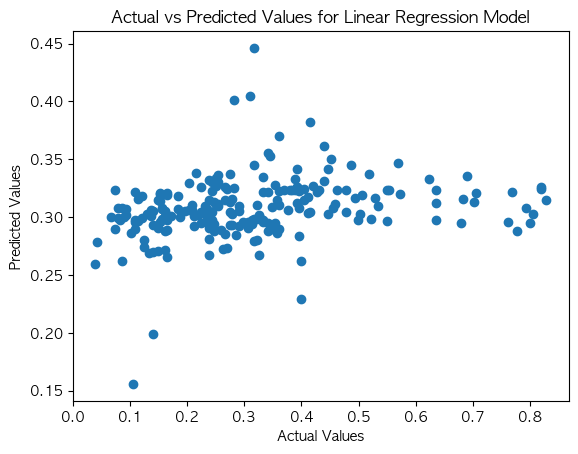

In [183]:
import matplotlib.pyplot as plt

# 산점도 그리기
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Linear Regression Model')
plt.show()


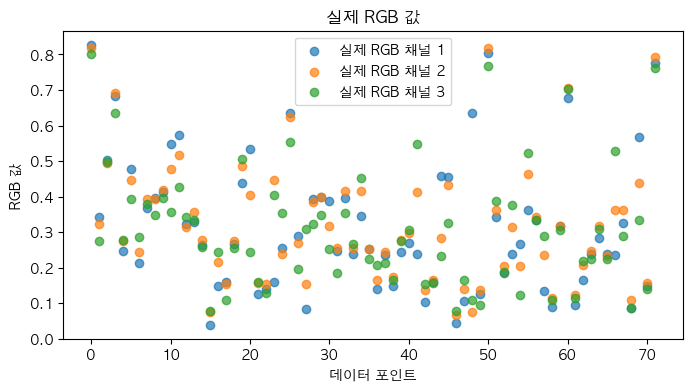

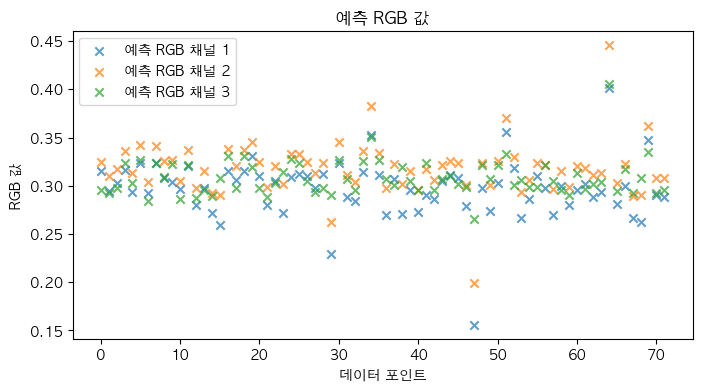

In [184]:
from matplotlib import rc
rc('font', family='AppleGothic')
# 실제 값 vs 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 RGB 채널 {i+1}', color=f'C{i}', marker='o', alpha=0.7)
    
plt.title('실제 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()
plt.show()

# 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_pred[:, i], label=f'예측 RGB 채널 {i+1}', color=f'C{i}', marker='x', alpha=0.7)

plt.title('예측 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()
plt.show()




## MLP

3/3 [==============================] - 0s 571us/step
Mean Squared Error: 0.030993192879156226
3/3 [==============================] - 0s 545us/step
Mean Squared Error: 0.030993192879156226


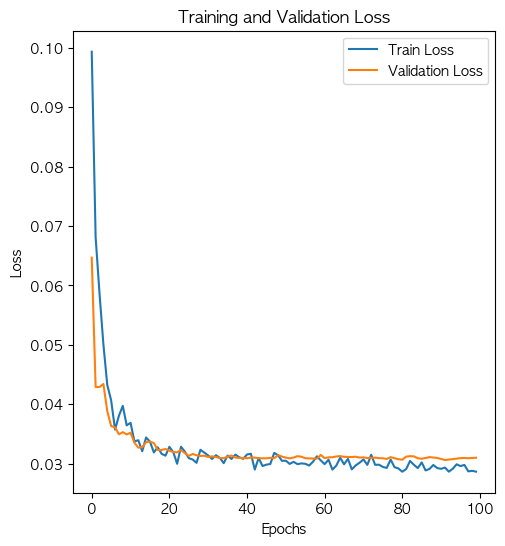

In [185]:
# 데이터 변환 함수
def convert_to_numeric(data):
    # RGB 값들을 0에서 1 사이의 실수 값으로 정규화
    # eval 함수를 사용하여 문자열 형태의 RGB 값을 파이썬 리스트로 변환
    return np.array([np.array(eval(rgb)) / 255.0 for rgb in data])

# X와 y 설정
# 'TOP_RGB'와 'BOTTOM_RGB' 열의 데이터를 숫자 형태로 변환하여 X와 y로 나눔
X = convert_to_numeric(result['TOP_RGB'].tolist())
y = convert_to_numeric(result['BOTTOM_RGB'].tolist())

# 훈련 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 선택 및 훈련 (MLP with Dropout)
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=3))
model.add(Dropout(0.5))  # 50%의 드롭아웃 비율
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 훈련
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)


# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


# 손실 그래프 시각화
plt.figure(figsize=(12, 6))

# 훈련 손실
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



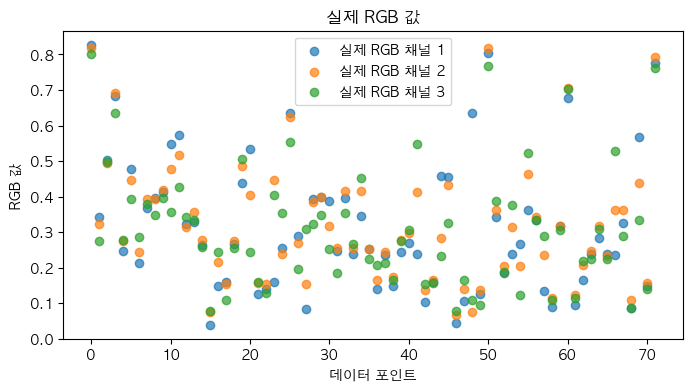

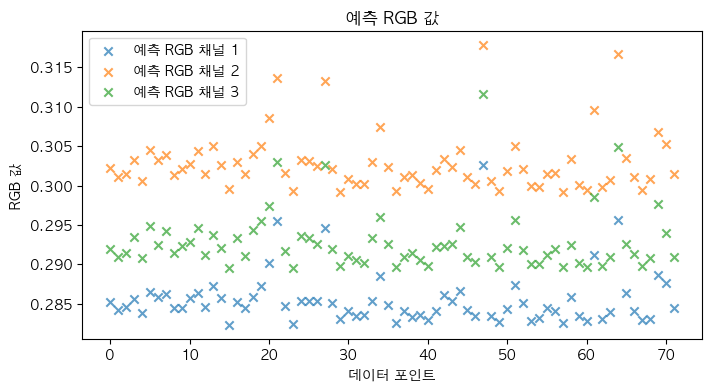

In [186]:
from matplotlib import rc
rc('font', family='AppleGothic')
# 실제 값 vs 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 RGB 채널 {i+1}', color=f'C{i}', marker='o', alpha=0.7)
    
plt.title('실제 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()
plt.show()

# 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_pred[:, i], label=f'예측 RGB 채널 {i+1}', color=f'C{i}', marker='x', alpha=0.7)

plt.title('예측 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()




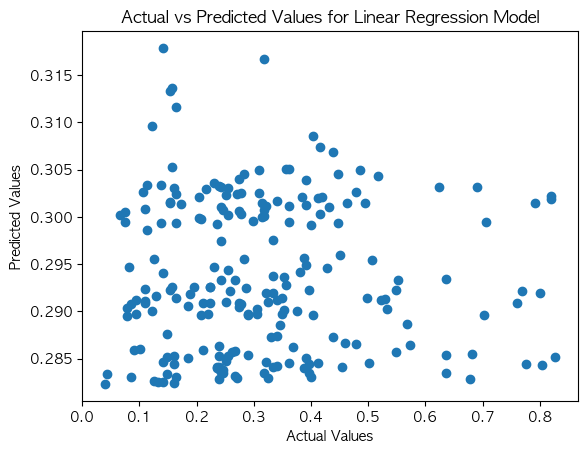

In [187]:
import matplotlib.pyplot as plt

# 산점도 그리기
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Linear Regression Model')
plt.show()


## RandomForest

In [188]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# RandomForestRegressor 모델 초기화
rf_model = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# 최적의 모델 얻기
best_rf_model = grid_search.best_estimator_

# 테스트 데이터로 예측
y_pred_rf = best_rf_model.predict(X_test)

# 모델 평가
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')



Random Forest Mean Squared Error: 0.036487098163032854


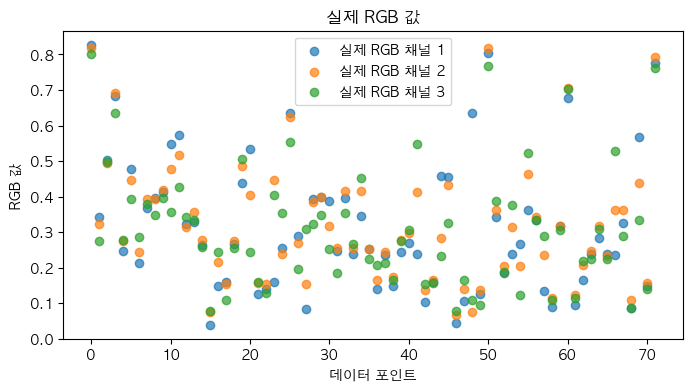

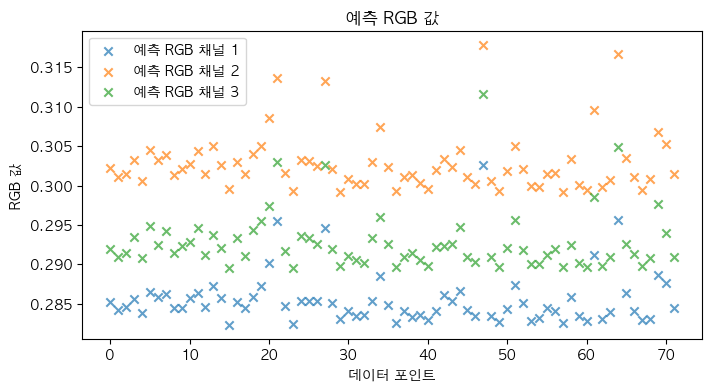

In [191]:
from matplotlib import rc
rc('font', family='AppleGothic')
# 실제 값 vs 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_test[:, i], label=f'실제 RGB 채널 {i+1}', color=f'C{i}', marker='o', alpha=0.7)
    
plt.title('실제 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()
plt.show()

# 예측 값 그래프
plt.figure(figsize=(8, 4))

# 3개의 RGB 성분에 대해 시각화
for i in range(3):
    plt.scatter(range(len(y_test)), y_pred[:, i], label=f'예측 RGB 채널 {i+1}', color=f'C{i}', marker='x', alpha=0.7)

plt.title('예측 RGB 값')
plt.xlabel('데이터 포인트')
plt.ylabel('RGB 값')
plt.legend()



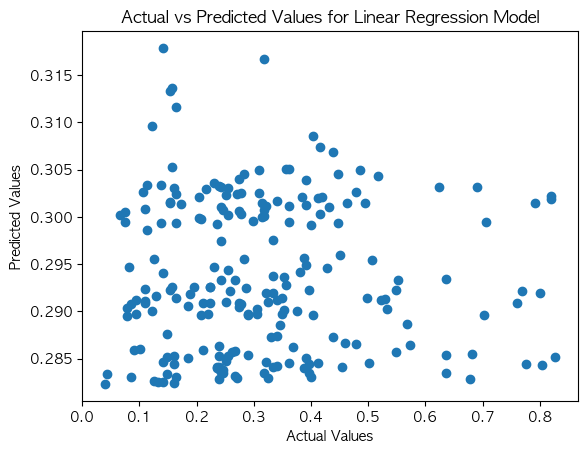

In [190]:
import matplotlib.pyplot as plt

# 산점도 그리기
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Linear Regression Model')
plt.show()



데이터 수가 부족해서 과적합이 일어난다고 판단했습니다.
현재 데이터는 총 300개 이지만 RGB 값이 0~255 범위의 3개 튜플로 이루어진 모델에서는 부족하다고 판단됩니다.
따라서, 데이터 양을 증가시켜 모델이 더 다양한 패턴을 학습하고 과적합을 방지하도록 하겠습니다.





